In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score # Optional, for another evaluation metric


In [2]:
np.random.seed(42)
num_customers = 200

In [3]:
data_dict = {
    'Annual_Spending_USD': np.concatenate([
        np.random.normal(500, 100, 50),   # Low Spenders
        np.random.normal(2000, 300, 50),  # Medium Spenders
        np.random.normal(5000, 800, 50),  # High Spenders
        np.random.normal(1200, 200, 50)   # Another medium group
    ]),
    'Customer_Age': np.concatenate([
        np.random.normal(25, 5, 50),      # Young
        np.random.normal(40, 7, 50),      # Middle-aged
        np.random.normal(55, 8, 50),      # Older
        np.random.normal(30, 6, 50)       # Younger, mixed
    ])
}
data = pd.DataFrame(data_dict)

In [4]:
# min 18 years old and min 100 USD spending
data['Annual_Spending_USD'] = data['Annual_Spending_USD'].apply(lambda x: max(x, 100))
data['Customer_Age'] = data['Customer_Age'].apply(lambda x: max(x, 18))


In [5]:
data.head()

,Annual_Spending_USD,Customer_Age
0,549.671415,26.788937
1,486.173570,27.803923
2,564.768854,30.415256
3,652.302986,30.269010
4,476.584663,18.111653


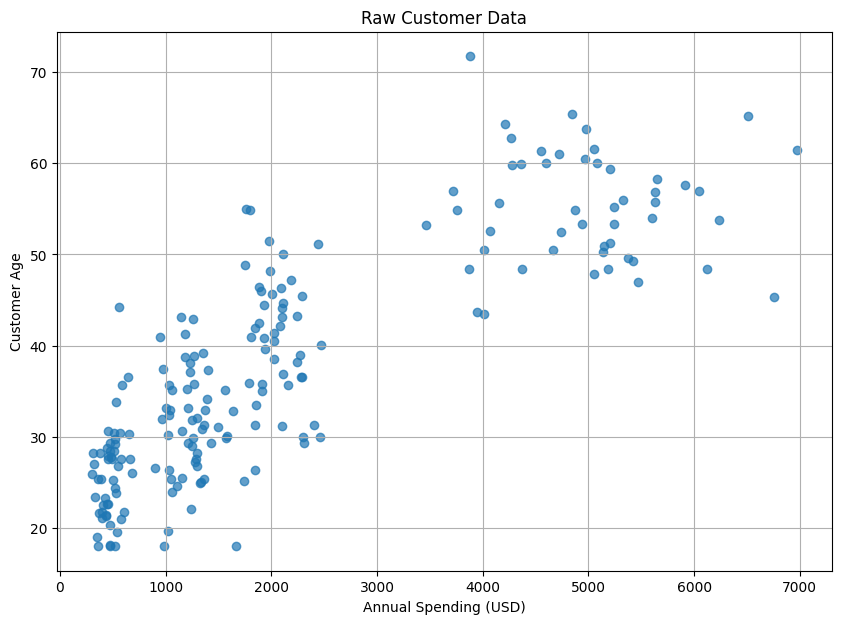

In [6]:
plt.figure(figsize=(10, 7))
plt.scatter(data['Annual_Spending_USD'], data['Customer_Age'], alpha=0.7)
plt.xlabel("Annual Spending (USD)")
plt.ylabel("Customer Age")
plt.title("Raw Customer Data")
plt.grid(True)
plt.show()

In [8]:
# This is CRUCIAL for K-Means as it's distance-based.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)


In [10]:
import random
def initialize_centroids(data, k):
    # Randomly select k data points as initial centroids
    indices = random.sample(range(data.shape[0]), k)
    centroids = data[indices]
    return centroids

k = 5
initial_centroids = initialize_centroids(scaled_data, k) # Initialize from scaled data
print("\nInitial Centroids (Scaled):\n", initial_centroids)



Initial Centroids (Scaled):
 [[-0.64281479 -0.4409419 ]
 [-0.51623121 -0.63908049]
 [-0.24038002 -1.01078682]
 [ 2.31453085  1.23979399]
 [-0.63520604 -0.99416797]]


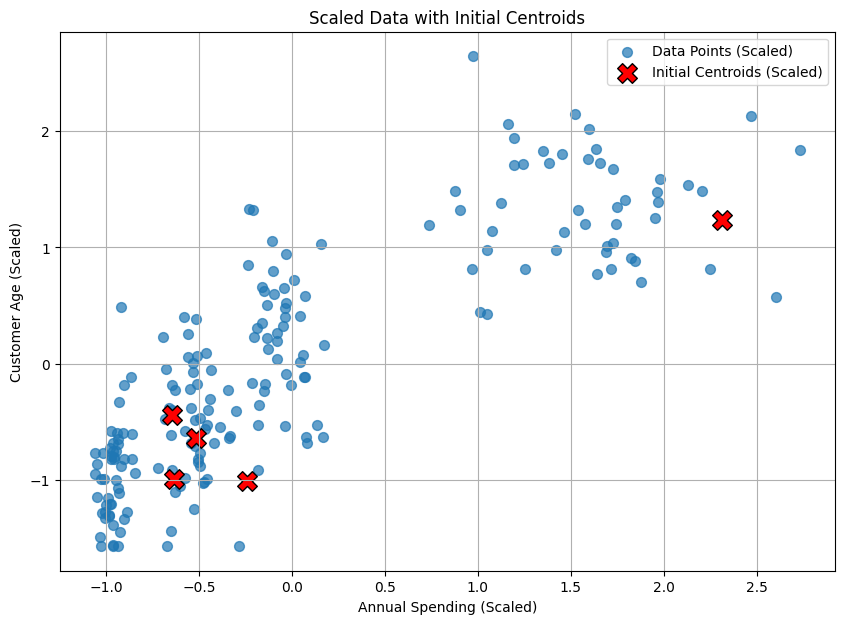

In [11]:
# Initial Centroids
plt.figure(figsize=(10, 7))
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], s=50, alpha=0.7, label='Data Points (Scaled)')
plt.scatter(initial_centroids[:, 0], initial_centroids[:, 1], s=200, marker='X', color='red', label='Initial Centroids (Scaled)', edgecolors='black')
plt.title("Scaled Data with Initial Centroids")
plt.xlabel("Annual Spending (Scaled)")
plt.ylabel("Customer Age (Scaled)")
plt.grid(True)
plt.legend()
plt.show()

### Assign Points to Nearest Centroids

In [12]:
def assign_to_clusters(data, centroids):
    # Calculate Euclidean distance from each point to each centroid
    # np.linalg.norm computes Euclidean norm (distance) along axis=2
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    # np.argmin finds the index of the minimum distance for each data point
    cluster_assignments = np.argmin(distances, axis=1)
    return cluster_assignments

In [13]:
def update_centroids(data, assignments, k):
    new_centroids = np.zeros((k, data.shape[1]))
    for i in range(k):
        # Find all data points assigned to cluster i
        points_in_cluster = data[assignments == i]
        if len(points_in_cluster) > 0:
            new_centroids[i] = np.mean(points_in_cluster, axis=0)
        else:
            # Handle empty clusters: re-initialize random point or keep old centroid.
            pass
    return new_centroids

In [15]:
# Test 1st train
centroids = initialize_centroids(scaled_data, k)
print("centroids : ",centroids)
assignments = assign_to_clusters(scaled_data, centroids)
print("assignments : ",assignments)

updated_centroids = update_centroids(scaled_data, assignments, k)
print("updated_centroids : ",updated_centroids)

centroids :  [[-0.494705   -0.87772524]
 [-0.93759369 -1.06760542]
 [ 2.2041531   1.48515154]
 [ 1.71330856  0.81584354]
 [-0.14589653 -0.17499987]]
assignments :  [1 1 1 0 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 4 4 4 4 4 4 4 4 4 4 4 4 0 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 2 2 3 2 2 3 2 3 3
 2 2 2 2 2 2 3 2 2 2 3 3 2 3 3 2 2 2 2 3 3 3 3 2 2 3 3 2 3 3 2 3 3 3 2 3 3
 3 3 0 4 4 0 0 0 0 0 0 0 0 4 0 0 4 0 0 0 0 0 0 0 4 4 4 0 4 0 4 0 0 0 1 0 0
 0 0 4 4 0 0 4 0 4 4 0 1 4 0 4]
updated_centroids :  [[-0.53031424 -0.7624964 ]
 [-0.9544423  -1.06209564]
 [ 1.73928742  1.73369856]
 [ 1.45611935  1.00032083]
 [-0.23361045  0.14554117]]


In [20]:
def kmeans(data, k, max_iterations=100, tolerance=1e-4):
    centroids = initialize_centroids(data, k)
    
    for i in range(max_iterations):
        old_centroids = centroids.copy()
        
        # Step 1: Assign points to nearest centroids
        assignments = assign_to_clusters(data, centroids)
        
        # Step 2: Update centroids
        centroids = update_centroids(data, assignments, k)
        
        # Check for convergence: if centroids don't move much
        if np.linalg.norm(centroids - old_centroids) < tolerance:
            print(f"K-Means converged after {i+1} iterations.")
            break
    else:
        print(f"K-Means reached max iterations ({max_iterations}) without converging.")
            
    return centroids, assignments

# Run the K-Means algorithm on the SCALED data
final_centroids_scaled, final_assignments = kmeans(scaled_data, k)

print("\nFinal Centroids (Scaled):\n", final_centroids_scaled)


K-Means converged after 9 iterations.

Final Centroids (Scaled):
 [[-0.39788835 -0.36978885]
 [ 1.2474565   1.47555561]
 [-0.8490552  -1.04600563]
 [ 1.96533885  1.21886089]
 [-0.15489513  0.50029336]]


In [21]:
final_assignments

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 0, 4, 4, 4, 0, 0, 4, 0, 4, 4, 0, 4, 2, 0, 4, 0,
       4, 0, 0, 4, 4, 0, 4, 4, 0, 4, 4, 0, 4, 0, 4, 4, 4, 0, 4, 0, 4, 4,
       4, 0, 4, 0, 0, 4, 4, 0, 4, 4, 4, 4, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3,
       1, 1, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3,
       1, 3, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 4, 2,
       0, 0, 4, 2, 2, 2, 2, 2, 2, 0, 0, 4, 0, 2, 2, 0, 2, 4, 0, 2, 2, 0,
       0, 0])

In [22]:
final_centroids_original_scale = scaler.inverse_transform(final_centroids_scaled)
final_centroids_original_scale

array([[1466.86414003,   33.31678971],
       [4362.2013188 ,   56.82724148],
       [ 672.93930699,   24.70150809],
       [5625.46929352,   53.55684452],
       [1894.4628376 ,   44.401997  ]])

Text(0.5, 1.0, 'K-Means Clustering Result')

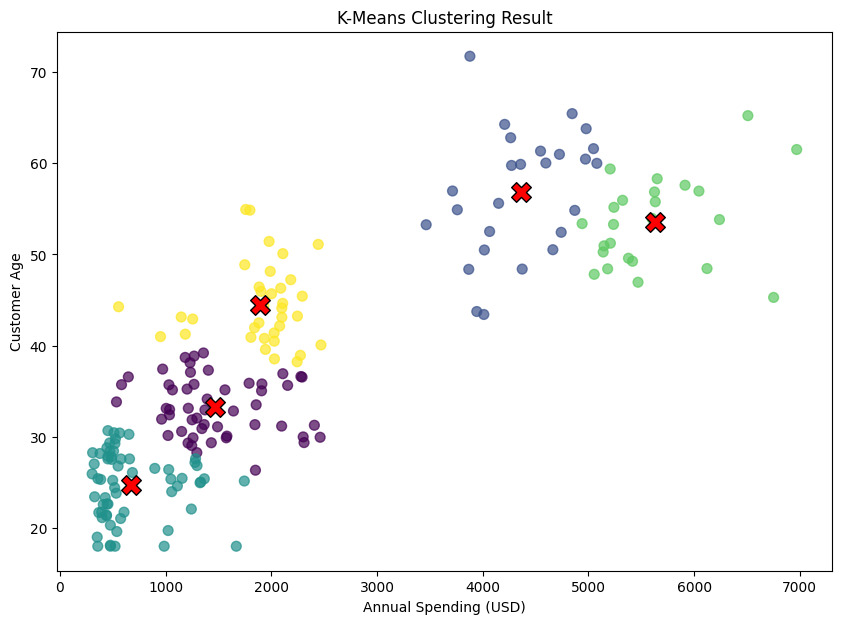

In [23]:
# Plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(data['Annual_Spending_USD'], data['Customer_Age'], c=final_assignments, s=50, alpha=0.7, cmap='viridis')
plt.scatter(final_centroids_original_scale[:, 0], final_centroids_original_scale[:, 1], s=200, marker='X', color='red', edgecolors='black')
plt.xlabel("Annual Spending (USD)")
plt.ylabel("Customer Age")
plt.title("K-Means Clustering Result")